# Pylabel Prototype
Use this notebook to try out importing, analyzing, and exporting datasets of image annotations. 

In [ ]:
from pylabel import importer
from pylabel import splitter 

In [3]:
#Import YAML File
yoloclasses =["bear","cottontail","coyote","dee","elk","foxgray","foxred","opossum","racoon","snowshoehare","turkey"]
out = importer.ImportYoloV5("../datasets/wildlife/yolo_splits/train/labels/", "329","329","jpeg",cat_names=yoloclasses, name="wildlife")


## Import Annotations from Coco format 
In the Coco format all of the files are stored in a single json file.

In [4]:
#Download the sample coco file so it can be read and imported
#!wget https://raw.githubusercontent.com/pylabel/notebook/main/test.json
#!wget https://raw.githubusercontent.com/pylabel/notebook/main/coco_instances_val2017.json

coco_annnotations = "tests/data/coco_instances_val2017.json"
coco_dataset = importer.ImportCoco(coco_annnotations)

#This should work without parens and with autocomplete 
coco_dataset.df.head(5)



,id,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,...,ann_area,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split
0,,,000000397133.jpg,,397133,640,427,,,217.62,...,1481.38065,"[[224.24, 297.18, 228.29, 297.18, 234.91, 298....",0.0,,,,44.0,bottle,kitchen,
1,,,000000397133.jpg,,397133,640,427,,,1.00,...,54085.62170,"[[292.37, 425.1, 340.6, 373.86, 347.63, 256.31...",0.0,,,,67.0,dining table,furniture,
2,,,000000397133.jpg,,397133,640,427,,,388.66,...,17376.91885,"[[446.71, 70.66, 466.07, 72.89, 471.28, 78.85,...",0.0,,,,1.0,person,person,
3,,,000000397133.jpg,,397133,640,427,,,135.57,...,123.19340,"[[136.18, 253.44, 153.89, 277.3, 157.89, 278.2...",0.0,,,,49.0,knife,kitchen,
4,,,000000397133.jpg,,397133,640,427,,,31.28,...,2136.46615,"[[37.61, 381.77, 31.28, 360.25, 40.15, 352.65,...",0.0,,,,51.0,bowl,kitchen,


# Export to VOC 


In [5]:
# print(coco_dataset.analyze.class_counts)
# print(coco_dataset.analyze.num_classes)
# print(coco_dataset.analyze.classes)
# print(coco_dataset.analyze.num_images)
#print(coco_dataset.analyze.split_counts)
#print(coco_dataset.analyze.split_pct)

#ExportToVoc(coco_dataset.df, segmented_=False, path_=False, database_=False, folder_=False, occluded_=False, write_to_file_=True, output_file_path_ = 'test_output/')
coco_dataset.export.ExportToVoc(coco_dataset.df, segmented_=False, path_=False, database_=False, folder_=False, occluded_=False, write_to_file_=True, output_file_path_ = 'test_output/')


KeyboardInterrupt: 

# Export to VOC XML


In [ ]:
coco_dataset_simple = coco_dataset.GroupShuffleSplit(coco_dataset.df, train_pct=0.6, test_pct=0.2, val_pct=0.2)
coco_dataset_stratified = coco_dataset.StratifiedGroupShuffleSplit(coco_dataset.df, train_pct=0.6, test_pct=0.2, val_pct=0.2, weight=0.01, batch_size=10)

coco_dataset_simple

,id,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,index
0,,,000000397133.jpg,,397133,640,427,,,217.62,...,"[[224.24, 297.18, 228.29, 297.18, 234.91, 298....",0.0,,,,44.0,bottle,kitchen,train,NaN
1,,,000000397133.jpg,,397133,640,427,,,1.00,...,"[[292.37, 425.1, 340.6, 373.86, 347.63, 256.31...",0.0,,,,67.0,dining table,furniture,train,NaN
3,,,000000397133.jpg,,397133,640,427,,,135.57,...,"[[136.18, 253.44, 153.89, 277.3, 157.89, 278.2...",0.0,,,,49.0,knife,kitchen,train,NaN
4,,,000000397133.jpg,,397133,640,427,,,31.28,...,"[[37.61, 381.77, 31.28, 360.25, 40.15, 352.65,...",0.0,,,,51.0,bowl,kitchen,train,NaN
5,,,000000397133.jpg,,397133,640,427,,,59.63,...,"[[135.7, 296.93, 133.83, 304.16, 120.3, 320.72...",0.0,,,,51.0,bowl,kitchen,train,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14727,,,000000015335.jpg,,15335,640,480,,,554.15,...,"[[557.44, 87.5, 554.15, 65.9, 560.25, 53.69, 5...",0.0,,,,1.0,person,person,test,36820.0
14728,,,000000015335.jpg,,15335,640,480,,,343.63,...,"[[400.45, 53.65, 382.13, 70.08, 379.79, 79.0, ...",0.0,,,,1.0,person,person,val,36823.0
14729,,,000000015335.jpg,,15335,640,480,,,160.39,...,"[[168.32, 151.37, 165.88, 141.01, 161.61, 133....",0.0,,,,1.0,person,person,test,36824.0
14730,,,000000015335.jpg,,15335,640,480,,,2.47,...,"[[26.58, 318.6, 47.35, 323.29, 46.01, 315.92, ...",0.0,,,,77.0,cell phone,electronic,val,36826.0


In [ ]:

coco_dataset.analyze.ShowClassSplits(coco_dataset_simple, normalize=False).round(4)



,all,train,test,val
cat_name,,,,
person,11004,6602,2194,2208.0
car,1932,1146,397,389.0
chair,1791,1046,371,374.0
book,1161,724,212,225.0
bottle,1025,600,216,209.0
...,...,...,...,...
toothbrush,57,35,15,7.0
microwave,55,29,10,16.0
scissors,36,17,9,10.0


In [ ]:
coco_dataset.analyze.ShowClassSplits(coco_dataset_stratified, normalize=True).round(4)


,all,train,test,val
cat_name,,,,
person,0.2992,0.3007,0.2967,0.2969
car,0.0525,0.0533,0.0513,0.0513
chair,0.0487,0.0499,0.0475,0.0464
book,0.0316,0.0332,0.0293,0.0289
bottle,0.0279,0.0284,0.0262,0.0280
...,...,...,...,...
toothbrush,0.0015,0.0012,0.0010,0.0033
microwave,0.0015,0.0017,0.0012,0.0011
scissors,0.0010,0.0008,0.0011,0.0014


## Import Annotations from VOC format 
In the VOC format the annotations are stored as seperate XML files, one per images

In [ ]:
#directory = "/Users/alex/Google Drive/pylabel/datasets/Cottontail-Rabbits.v1-augmented-data.voc/train"
!git clone https://github.com/Shenggan/BCCD_Dataset 
directory = 'BCCD_Dataset/BCCD/Annotations/'
#directory = "test_output/"

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


In [ ]:
#voc_dataset.df.filter(regex='ann*')
voc_dataset =  importer.ImportVOC(directory, name="BCCD")

voc_dataset.df.head(10)


<DirEntry 'BloodImage_00315.xml'>
<DirEntry 'BloodImage_00301.xml'>
<DirEntry 'BloodImage_00117.xml'>
<DirEntry 'BloodImage_00103.xml'>
<DirEntry 'BloodImage_00088.xml'>
<DirEntry 'BloodImage_00063.xml'>
<DirEntry 'BloodImage_00077.xml'>
<DirEntry 'BloodImage_00261.xml'>
<DirEntry 'BloodImage_00275.xml'>
<DirEntry 'BloodImage_00249.xml'>
<DirEntry 'BloodImage_00248.xml'>
<DirEntry 'BloodImage_00274.xml'>
<DirEntry 'BloodImage_00260.xml'>
<DirEntry 'BloodImage_00076.xml'>
<DirEntry 'BloodImage_00062.xml'>
<DirEntry 'BloodImage_00089.xml'>
<DirEntry 'BloodImage_00300.xml'>
<DirEntry 'BloodImage_00314.xml'>
<DirEntry 'BloodImage_00302.xml'>
<DirEntry 'BloodImage_00100.xml'>
<DirEntry 'BloodImage_00114.xml'>
<DirEntry 'BloodImage_00074.xml'>
<DirEntry 'BloodImage_00048.xml'>
<DirEntry 'BloodImage_00289.xml'>
<DirEntry 'BloodImage_00276.xml'>
<DirEntry 'BloodImage_00262.xml'>
<DirEntry 'BloodImage_00263.xml'>
<DirEntry 'BloodImage_00277.xml'>
<DirEntry 'BloodImage_00288.xml'>
<DirEntry 'Blo

,id,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,...,ann_area,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split
0,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
1,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
2,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
3,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
4,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
5,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
6,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
7,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
8,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,
9,11,JPEGImages,BloodImage_00315.jpg,NaN,0,640,480,3,0,567.0,...,2236.0,NaN,NaN,Unspecified,0,0,2,Platelets,NaN,


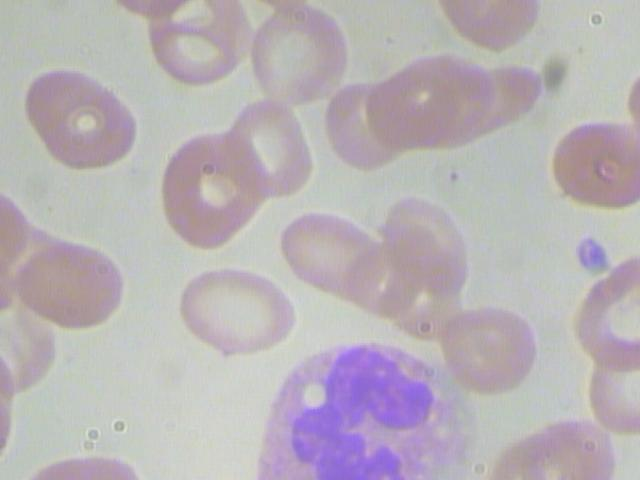

In [ ]:
from os.path import exists
from IPython.display import Image


#file_exists = exists("BCCD_Dataset/BCCD/../BCCD/JPEGImages/"+"BloodImage_00315.jpg") 
Image(directory+"../JPEGImages/" + "BloodImage_00315.jpg") 

#file_exists

# print(voc_dataset.analyze.class_counts)
# print(voc_dataset.analyze.num_classes)
# print(voc_dataset.analyze.classes)
# print(voc_dataset.analyze.num_images)
# print(voc_dataset.analyze.split_counts)
# print(voc_dataset.analyze.split_pct)

In [ ]:
stratified_split_df = voc_dataset.StratifiedGroupShuffleSplit(voc_dataset.df, train_pct=0.6, test_pct=0.2, val_pct=0.2, weight=0.01, batch_size=5)
simple_split_df = voc_dataset.GroupShuffleSplit(voc_dataset.df)



In [ ]:
voc_dataset.analyze.ShowClassSplits(stratified_split_df).round(2)

,all,train,test,val
cat_name,,,,
person,0.30,0.30,0.30,0.30
chair,0.05,0.05,0.05,0.05
car,0.04,0.04,0.04,0.04
book,0.04,0.04,0.04,0.04
dining table,0.03,0.03,0.03,0.03
...,...,...,...,...
nan,0.00,0.00,0.00,0.00
dog,0.00,0.00,0.00,0.00
scissors,0.00,0.00,0.00,0.00


In [ ]:
voc_dataset.analyze.ShowClassSplits(simple_split_df).round(2)

,all,train,test,val
cat_name,,,,
person,0.30,0.30,0.30,0.31
chair,0.05,0.05,0.05,0.05
car,0.04,0.04,0.04,0.04
book,0.04,0.04,0.04,0.04
dining table,0.03,0.03,0.03,0.03
...,...,...,...,...
nan,0.00,0.00,0.00,0.00
dog,0.00,0.00,0.00,0.00
scissors,0.00,0.00,0.00,0.00


In [ ]:
voc_dataset.analyze.ShowClassSplits(stratified_split_df).round(2)

,all,train,test,val
cat_name,,,,
person,0.30,0.30,0.30,0.30
chair,0.05,0.05,0.05,0.05
car,0.04,0.04,0.04,0.04
book,0.04,0.04,0.04,0.04
dining table,0.03,0.03,0.03,0.03
...,...,...,...,...
nan,0.00,0.00,0.00,0.00
dog,0.00,0.00,0.00,0.00
scissors,0.00,0.00,0.00,0.00


In [6]:
#!pip install jupyter_innotater
from jupyter_innotater import *
import numpy as np, os

images = os.listdir('BCCD_Dataset/BCCD/JPEGImages/')
targets = np.zeros((len(images), 4)) # Initialise bounding boxes as x,y = 0,0, width,height = 0,0
Innotater( ImageInnotation(images, path='./BCCD_Dataset/BCCD/JPEGImages/'), BoundingBoxInnotation(targets) )

Innotater(children=(HBox(children=(VBox(children=(ImagePad(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x0…

In [ ]:
import xml.etree.ElementTree as ET
import xml.dom.minidom  